In [ ]:
#libraries installation
!pip install roboflow
!pip install ultralytics
!pip install wandb

In [ ]:
from roboflow import Roboflow
import os
from kaggle_secrets import UserSecretsClient
# use this code for load dataset from roboflow
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("Roboflow_thermal")
rf = Roboflow(api_key=secret_value_0)
project = rf.workspace("mineguard").project("mineguard-thermal-hnhpg")
version = project.version(1)
dataset = version.download("yolov8")

In [ ]:
from ultralytics import YOLO
import ray
from ray import tune
import wandb


secret_value_1 = user_secrets.get_secret("WANDB_THERMAL")# specify api key for wandb login

os.environ["WANDB_API_KEY"] = secret_value_1

wandb.login()

wandb.init(project="Thermal_photo")# specify project in wandb

ray.init(num_gpus=2)# specify that 2 GPU should be used


In [ ]:
model = YOLO('yolov8s.pt') #load pre-trained model, yolov8s was chosen according to capacity Nvidia Jetson Nano

In [ ]:
#find best parameters for model
result_grid = model.tune(
    data= "/kaggle/working/MineGuard-Thermal-1/data.yaml",
    space={
        "lr0": tune.uniform(1e-5, 1e-1),
        "momentum": tune.uniform(0.6, 0.98),
        "weight_decay": tune.uniform(0.0, 0.001),
        "optimizer": "adamW"
    },
    epochs=10,
    use_ray=True,
    iterations=5,
    gpu_per_trial=2,

)

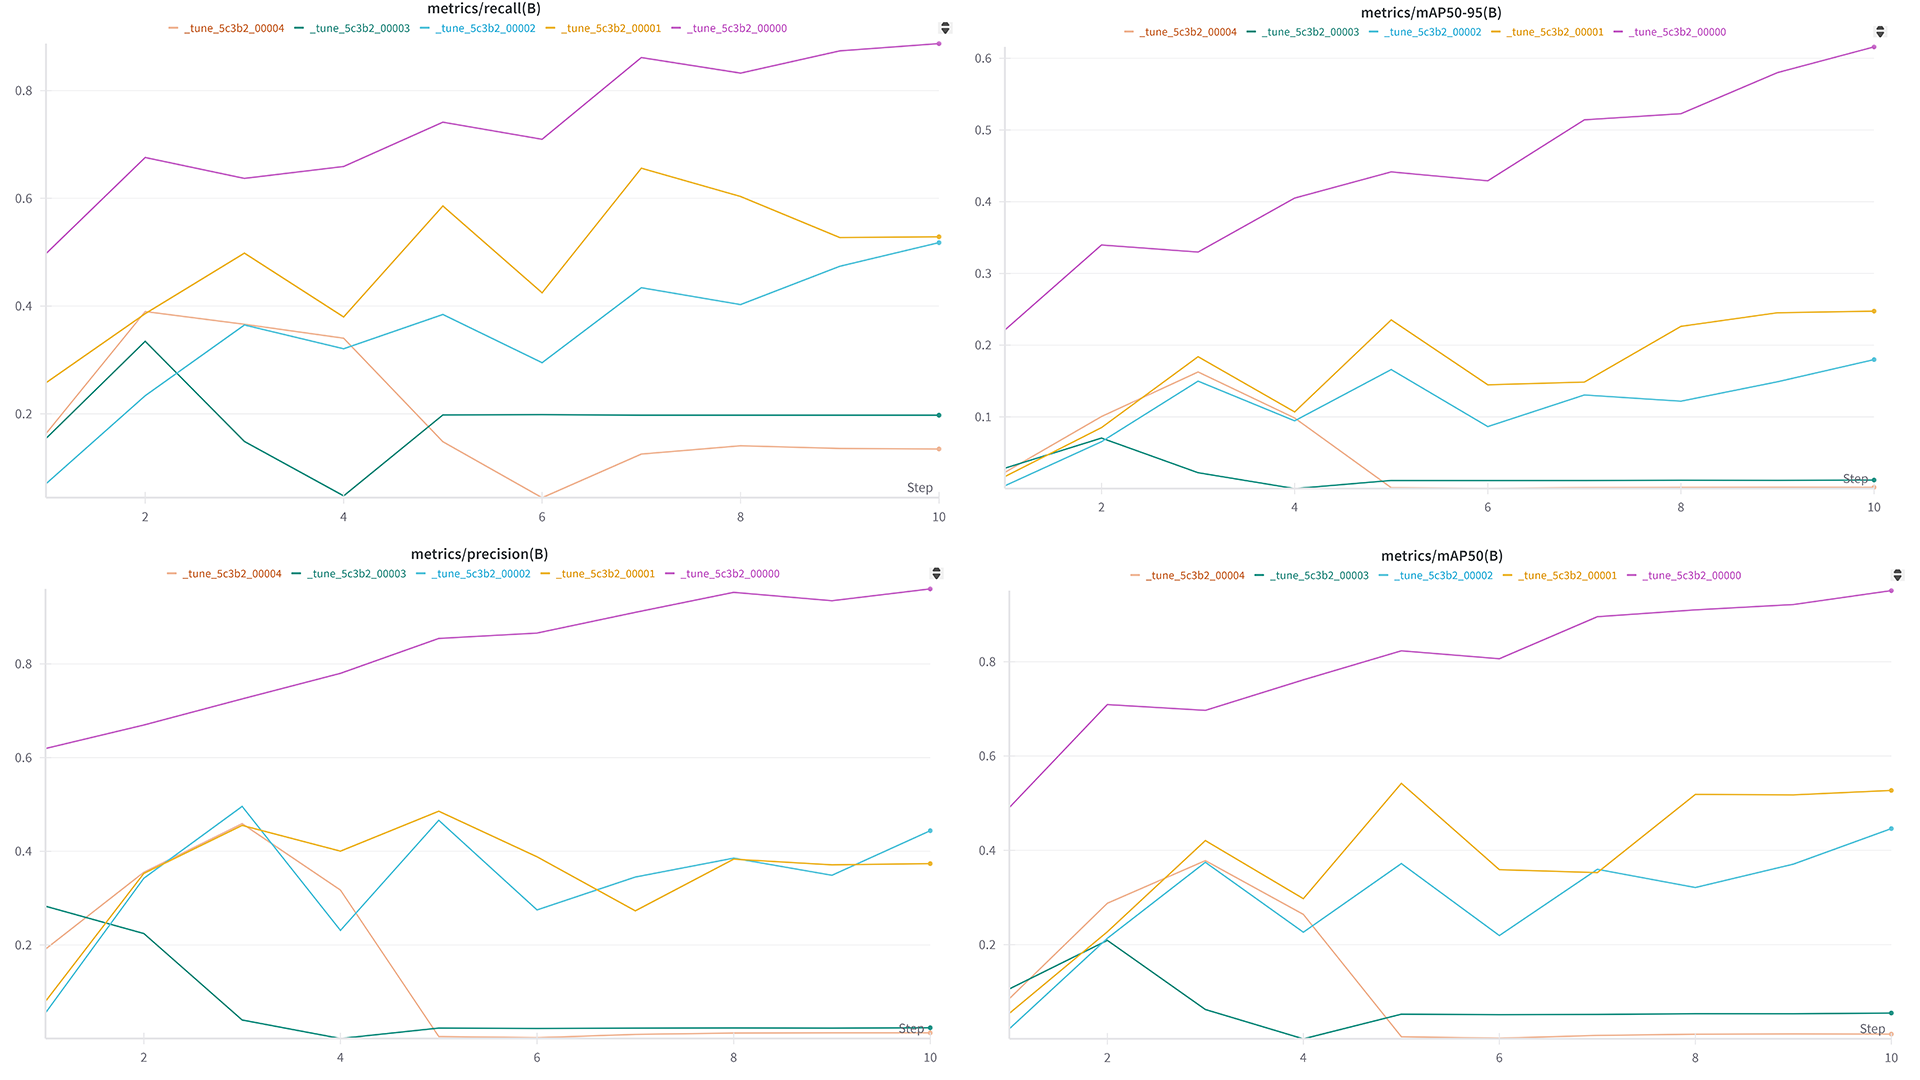

In [ ]:
!zip -r runs.zip /kaggle/working/runs

In [ ]:
api = wandb.Api()
run_path = "gr0nt0nbith-khpi/YOLOv8-tune/5c3b2_00000"
run = api.run(run_path)

config = run.config

True


In [ ]:
#load best config from wandb
hyperparameters = {
    "data": "/kaggle/working/MineGuard-Thermal-1/data.yaml",
    "epochs": 30,
    "lr0": config["lr0"],
    "momentum": config["momentum"],
    "weight_decay": config["weight_decay"],
    "batch": 64,
    "imgsz": 640,
}

In [ ]:
model.train(**hyperparameters, device = [0,1], verbose=True) # trian model using custom dataset. for train used 2 GPU T4

In [ ]:
results = model.val(data="/kaggle/working/MineGuard-Thermal-1/data.yaml") # evaluate the accuracy of the model on a test data set

$$
\begin{array}{lrrrrrr}
\hline
\text{Class} & \text{Images} & \text{Instances} & \text{P} & \text{R} & \text{mAP@0.5} & \text{mAP@0.5:0.95} \\
\hline
\text{all}   & 1001 & 2011 & 0.968 & 0.952 & 0.987 & 0.765 \\
\hline
\end{array}
$$


The trained model performs exceptionally on thermal imagery dataset. Precision of 96.8% and recall of 95.2% indicate low false positives and few missed detections. The mAP@0.5 of 0.987 reflects near-perfect detection quality, while mAP@0.5:0.95 at 0.765 shows robust localization despite thermal imaging challenges. These results confirm the model’s effectiveness for mine detection.

**Test the model on real data.**

In [ ]:
#download test video and model from google drive
!gdown "16ZpZhVOVpkXtqAmrDSsgTfYdYXXcWvKP"
!gdown "1d0mFF3d7YkRw838oVzzrAYXMugs3ByFz"

In [ ]:
import cv2
import numpy as np


# load the YOLO model
model = YOLO('/kaggle/working/best_thermal.pt')

# path to the input video
video_path = '/kaggle/working/1719165021347.mp4'
cap = cv2.VideoCapture(video_path)

# check if the video file opened successfully
if not cap.isOpened():
    print("Error: Could not open video file")
    exit()

# set up the output video writer
output_path = '/kaggle/working/output_thermal_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
class_names = model.names # extract names of classses for drawing bounding boxes

ret = True
while ret:
    ret, frame = cap.read()
    if ret:
        # detect and track objects in the frame
        results = model.track(frame, persist=True)

        # extract detection data
        boxes = results[0].boxes.xyxy.cpu().numpy()  # bounding box
        confs = results[0].boxes.conf.cpu().numpy()  # confidence scores
        ids = results[0].boxes.id.cpu().numpy() if results[0].boxes.id is not None else None  # tracking ID
        classes = results[0].boxes.cls.cpu().numpy()
        # draw bounding boxes
        for i, box in enumerate(boxes):
            conf = confs[i]
            if conf >= 0.4:  # draw boxes if confidence > 40%
                x1, y1, x2, y2 = map(int, box)
                obj_id = int(ids[i]) if ids is not None else -1

                class_id = int(classes[i])
                class_name = class_names[class_id]

                # draw bounding box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # add label with ID, confidence and classes
                label = f'ID: {obj_id} Conf: {conf:.2f} {class_name}'
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Write the processed frame to the output video
        out.write(frame)

# Release resources when done
cap.release()
out.release()


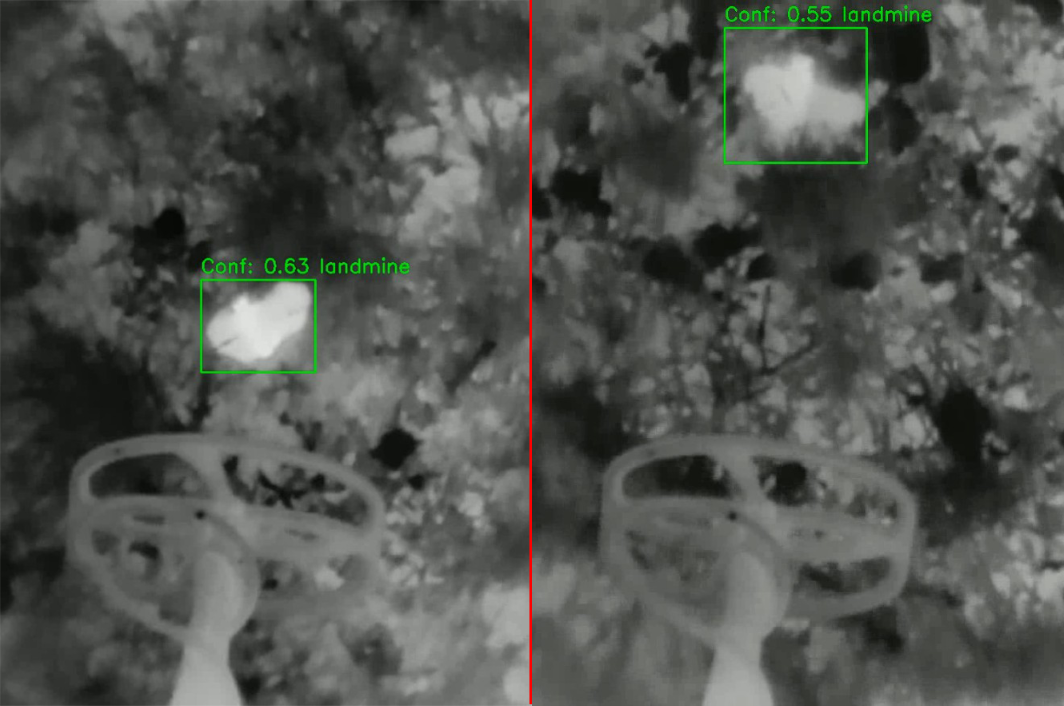